<a href="https://colab.research.google.com/github/bULK2403/finals/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Библиотеки

In [ ]:
import csv
import math
import statistics
from collections import Counter, defaultdict
from typing import List, Dict, Any, Optional, Tuple


In [ ]:
# -------------------------
# Утилиты для работы со значениями
# -------------------------
MISSING_TOKENS = {"", "na", "n/a", "none", "nan", "null", "пусто", "неизвестно", "NA", "None", "NaN", "NULL"}

def is_missing(val: Any) -> bool:
    """Определяет, считается ли значение пропуском."""
    if val is None:
        return True
    s = str(val).strip()
    return s == "" or s in MISSING_TOKENS

def try_parse_float(s: Any) -> Optional[float]:
    """Пытаемся безопасно преобразовать к float, иначе None.
    """
    try:
        if s is None:
            return None
        ss = str(s).strip()
        if is_missing(ss):
            return None

        # убрать пробелы и неразрывные пробелы, апострофы (тысячные разделители)
        ss = ss.replace("\u00A0", "").replace(" ", "").replace("'", "")

        has_dot = '.' in ss
        has_comma = ',' in ss

        if has_dot and has_comma:
            # если есть и точка, и запятая — считаем за десятичный тот, который стоит правее
            if ss.rfind('.') > ss.rfind(','):
                # точка — десятичная, убираем все запятые (разделители тысяч)
                ss = ss.replace(',', '')
            else:
                # запятая — десятичная, убираем точки как разделители тысяч и заменяем запятую на точку
                ss = ss.replace('.', '')
                ss = ss.replace(',', '.')
        elif has_comma and not has_dot:
            # только запятые: решаем — тысячи или десятичная запятая
            parts = ss.split(',')
            # если все части, кроме первой, ровно по 3 цифры — вероятно это разделители тысяч
            if len(parts) > 1 and all(len(p) == 3 for p in parts[1:]):
                ss = ss.replace(',', '')
            else:
                # иначе — считаем запятую десятичной
                ss = ss.replace(',', '.')
        # иначе: только точки или ни того ни другого — оставляем как есть

        return float(ss)
    except Exception:
        return None

# -------------------------
# Чтение/печать CSV
# -------------------------
# ---- Улучшенное чтение CSV с детекцией разделителя и поддержкой BOM ----
def detect_delimiter(sample: str) -> str:
    """
    Попробуем угадать разделитель: csv.Sniffer или подсчёт символов.
    Вернём ';' или ',' или '\t' (в порядке приоритета).
    """
    try:
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample, delimiters=[',',';','\t','|'])
        return dialect.delimiter
    except Exception:
        choices = {
            ',': sample.count(','),
            ';': sample.count(';'),
            '\t': sample.count('\t'),
            '|': sample.count('|')
        }
        best = max(choices.items(), key=lambda x: x[1])
        return best[0] if best[1] > 0 else ','

def read_csv(path: str, encoding: str = "utf-8-sig"):
    """
    CSV-чтение:
    - корректно убирает BOM
    - автоматически определяет разделитель
    """
    with open(path, "r", encoding=encoding, newline="") as f:
        sample = f.read(4096)

    delimiter = detect_delimiter(sample)

    rows = []
    with open(path, newline="", encoding=encoding) as f:
        reader = csv.DictReader(f, delimiter=delimiter)
        header = reader.fieldnames or []
        header = [h.lstrip("\ufeff") for h in header]

        for r in reader:
            clean_row = {}
            for h in header:
                clean_row[h] = r.get(h, "") if r.get(h) is not None else ""
            rows.append(clean_row)

    return header, rows

def print_head(header, rows, n=5):
    print(" | ".join(header))
    for i, r in enumerate(rows[:n]):
        print(f"{i} | " + " | ".join(str(r.get(h, "")) for h in header))

# -------------------------
# Пропуски
# -------------------------
def count_missing_by_column(header: List[str], rows: List[Dict[str, str]]) -> Dict[str, int]:
    counts = {h: 0 for h in header}
    for r in rows:
        for h in header:
            if is_missing(r.get(h, "")):
                counts[h] += 1
    return counts

def where_missing(header: List[str], rows: List[Dict[str, str]]) -> Dict[str, List[int]]:
    """Возвращает индексы строк (0-based), где пропуск для каждой колонки."""
    locs: Dict[str, List[int]] = {h: [] for h in header}
    for i, r in enumerate(rows):
        for h in header:
            if is_missing(r.get(h, "")):
                locs[h].append(i)
    return locs

# -------------------------
# Определение типа колонки (числовая/категориальная)
# -------------------------
def detect_numeric_columns(header: List[str], rows: List[Dict[str, str]], threshold: float = 0.8) -> List[str]:
    """
    Считает колонку числовой, если доля значений, успешно парсящихся в float, >= threshold.
    """
    numeric_cols = []
    n = len(rows)
    for h in header:
        parsed = 0
        total = 0
        for r in rows:
            v = r.get(h, "")
            if is_missing(v):
                continue
            total += 1
            if try_parse_float(v) is not None:
                parsed += 1
        # если почти все непустые значения парсятся в float -> числовая
        if total == 0:
            # если колонка пустая — не считать её числовой
            continue
        if parsed / total >= threshold:
            numeric_cols.append(h)
    return numeric_cols

# -------------------------
# Заполнение пропусков (мода/медиана)
# -------------------------
def fill_missing_with_mode(header: List[str], rows: List[Dict[str, str]], columns: Optional[List[str]] = None) -> None:
    """
    Заполнение пропусков модой для заданных колонок (или для всех нечисловых).
    Модифицирует rows in place.
    """
    if columns is None:
        # если не указано — вычислим нечисловые колонки автоматически
        numeric = set(detect_numeric_columns(header, rows))
        columns = [h for h in header if h not in numeric]
    for h in columns:
        counter = Counter()
        for r in rows:
            v = r.get(h, "")
            if not is_missing(v):
                counter[str(v).strip()] += 1
        if len(counter) == 0:
            continue
        mode_val, _ = counter.most_common(1)[0]
        # заполнить
        for r in rows:
            if is_missing(r.get(h, "")):
                r[h] = mode_val

def fill_missing_with_median(header: List[str], rows: List[Dict[str, str]], columns: Optional[List[str]] = None) -> None:
    """
    Заполнение пропусков медианой для числовых колонок.
    Модифицирует rows in place.
    """
    if columns is None:
        columns = detect_numeric_columns(header, rows)
    for h in columns:
        vals = []
        for r in rows:
            f = try_parse_float(r.get(h, ""))
            if f is not None:
                vals.append(f)
        if not vals:
            continue
        med = statistics.median(vals)
        for r in rows:
            if try_parse_float(r.get(h, "")) is None:
                # записывать как строку — сохраняем единообразие типа (CSV-like)
                r[h] = str(med)

# -------------------------
# Выбросы по IQR
# -------------------------
def quantile(sorted_vals: List[float], p: float) -> float:
    """
    Простой квантиль с линейной интерполяцией (p в [0,1]).
    """
    if not sorted_vals:
        raise ValueError("Empty list in quantile")
    n = len(sorted_vals)
    if n == 1:
        return sorted_vals[0]
    pos = p * (n - 1)
    lower = int(math.floor(pos))
    upper = int(math.ceil(pos))
    if lower == upper:
        return sorted_vals[lower]
    frac = pos - lower
    return sorted_vals[lower] * (1 - frac) + sorted_vals[upper] * frac

def detect_outliers_iqr(header: List[str], rows: List[Dict[str, str]], multiplier: float = 1.5) -> Dict[str, List[int]]:
    """
    Возвращает для каждой числовой колонки список индексов строк, считающихся выбросами по IQR.
    """
    numeric = detect_numeric_columns(header, rows)
    outliers: Dict[str, List[int]] = {}
    for h in numeric:
        vals = []
        idx_map = []
        for i, r in enumerate(rows):
            f = try_parse_float(r.get(h, ""))
            if f is not None:
                vals.append(f)
                idx_map.append(i)
        if not vals:
            outliers[h] = []
            continue
        sorted_vals = sorted(vals)
        q1 = quantile(sorted_vals, 0.25)
        q3 = quantile(sorted_vals, 0.75)
        iqr = q3 - q1
        lower = q1 - multiplier * iqr
        upper = q3 + multiplier * iqr
        out_idx = []
        # проверяем все строки (включая те, где значение было пропуск -> не считаем)
        for i, r in enumerate(rows):
            f = try_parse_float(r.get(h, ""))
            if f is None:
                continue
            if f < lower or f > upper:
                out_idx.append(i)
        outliers[h] = out_idx
    return outliers

# -------------------------
# Масштабирование / стандартизация
# -------------------------
# -------------------------
# In-place Min-Max и Z-стандартизация (замена значений признаков)
# -------------------------
def min_max_scale_inplace(header: List[str], rows: List[Dict[str, str]], columns: Optional[List[str]] = None,
                          feature_range: Tuple[float, float] = (0.0, 1.0)) -> None:
    """
    Выполняет Min-Max масштабирование IN-PLACE для указанных колонок.
    По формуле: x' = (x - min) / (max - min), затем масштаб в заданный feature_range.
    Если max == min -> все значения заменяются на среднее (что эквивалентно 0.0 в нормированной шкале),
    но тут записываем middle of feature_range (обычно 0.0 для [0,0]).
    Пропуски оставляем пустыми.
    """
    if columns is None:
        columns = detect_numeric_columns(header, rows)
    a, b = feature_range
    for h in columns:
        vals = []
        for r in rows:
            f = try_parse_float(r.get(h, ""))
            if f is not None:
                vals.append(f)
        if not vals:
            # нет числовых значений — пропускаем
            continue
        vmin = min(vals)
        vmax = max(vals)
        denom = vmax - vmin
        # значение по умолчанию, если все одинаковы: центр диапазона
        default_mapped = str((a + b) / 2.0)
        for r in rows:
            f = try_parse_float(r.get(h, ""))
            if f is None:
                # оставляем пустым (или можно поставить default_mapped — зависит от политики)
                r[h] = ""
            else:
                if denom == 0:
                    r[h] = default_mapped
                else:
                    scaled = (f - vmin) / denom  # в [0,1]
                    mapped = a + scaled * (b - a)
                    r[h] = str(mapped)

def z_standardize_inplace(header: List[str], rows: List[Dict[str, str]], columns: Optional[List[str]] = None) -> None:
    """
    Выполняет Z-стандартизацию IN-PLACE для указанных колонок:
    x' = (x - mean) / std. Если std == 0 -> записываем "0.0".
    Пропуски оставляем пустыми.
    """
    if columns is None:
        columns = detect_numeric_columns(header, rows)
    for h in columns:
        vals = []
        for r in rows:
            f = try_parse_float(r.get(h, ""))
            if f is not None:
                vals.append(f)
        if not vals:
            continue
        mean = sum(vals) / len(vals)
        std = statistics.pstdev(vals)  # population stdev
        for r in rows:
            f = try_parse_float(r.get(h, ""))
            if f is None:
                r[h] = ""
            else:
                if std == 0:
                    r[h] = "0.0"
                else:
                    r[h] = str((f - mean) / std)

# -------------------------
# Ordinal (порядковое) кодирование
# -------------------------
def ordinal_encode_column(values: List[str], mapping: Optional[Dict[str, int]] = None) -> Tuple[List[int], Dict[str, int]]:
    """
    Кодируем список категорий в целые числа.
    Если mapping не задан, создаём по отсортированным уникальным значениям.
    Возвращаем (encoded_list, mapping).
    """
    if mapping is None:
        uniq = sorted({str(v).strip() for v in values if not is_missing(v)})
        mapping = {v: i for i, v in enumerate(uniq)}
    encoded = []
    for v in values:
        if is_missing(v):
            encoded.append(None)
        else:
            encoded.append(mapping.get(str(v).strip(), None))
    return encoded, mapping

def ordinal_encode(header: List[str], rows: List[Dict[str, str]], columns: List[str], new_suffix: str = "_ord", provided_mappings: Optional[Dict[str, Dict[str, int]]] = None) -> Dict[str, Dict[str, int]]:
    """
    Добавляет новые колонки с порядковым кодированием (числами). Возвращает используемые отображения.
    provided_mappings: опционально можно передать уже готовые словари по колонкам.
    """
    mappings: Dict[str, Dict[str, int]] = {}
    for h in columns:
        vals = [r.get(h, "") for r in rows]
        mapping = None
        if provided_mappings and h in provided_mappings:
            mapping = provided_mappings[h]
        encoded, mapping = ordinal_encode_column(vals, mapping)
        mappings[h] = mapping
        new_key = h + new_suffix
        for r, code in zip(rows, encoded):
            r[new_key] = "" if code is None else str(code)
    return mappings

# -------------------------
# One-Hot кодирование
# -------------------------
def one_hot_encode(header: List[str], rows: List[Dict[str, str]], columns: List[str], prefix_sep: str = "_") -> List[str]:
    """
    Создаёт бинарные столбцы для каждого уникального значения в перечисленных колонках.
    Возвращает список новых колонок, и модифицирует rows (добавляет новые ключи).
    """
    new_cols = []
    for h in columns:
        uniq = sorted({str(r.get(h, "")).strip() for r in rows if not is_missing(r.get(h, ""))})
        for u in uniq:
            new_col = f"{h}{prefix_sep}{u}"
            new_cols.append(new_col)
            for r in rows:
                r[new_col] = "1" if (not is_missing(r.get(h, "")) and str(r.get(h, "")).strip() == u) else "0"
    return new_cols

# -------------------------
# Удаление дубликатов
# -------------------------
def remove_duplicates(header: List[str], rows: List[Dict[str, str]], subset: Optional[List[str]] = None) -> List[Dict[str, str]]:
    """
    Удаляет дубликаты. Если subset указана — считаем дубликатом строки с одинаковыми значениями в subset колонках.
    Возвращаем новый список строк (копию без дубликатов), оставляя первый встретившийся.
    """
    seen = set()
    out = []
    if subset is None:
        subset = header
    for r in rows:
        key = tuple((r.get(h, "") or "").strip() for h in subset)
        if key in seen:
            continue
        seen.add(key)
        out.append(r)
    return out

# -------------------------
# Сохранение CSV (при необходимости)
# -------------------------
def write_csv(path: str, header: List[str], rows: List[Dict[str, str]], encoding: str = "utf-8") -> None:
    with open(path, "w", newline="", encoding=encoding) as f:
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writeheader()
        for r in rows:
            # убедимся, что все ключи присутствуют
            row_out = {k: (r.get(k, "") if r.get(k, "") is not None else "") for k in header}
            writer.writerow(row_out)


Применение

In [ ]:
# -------------------------
# Применение функций на примере датасета /content/tinkof.csv
# -------------------------
if __name__ == "__main__":
    CSV_PATH = "/content/tinkof.csv"
    try:
        header, rows = read_csv(CSV_PATH)
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл не найден: {CSV_PATH}. Загрузите файл в Colab по этому пути.")

    print("== Заголовок и первые строки ==")
    print_head(header, rows, n=6)

    print("\n== Пропуски по колонкам (количество) ==")
    missing_counts = count_missing_by_column(header, rows)
    for col, cnt in missing_counts.items():
        print(f"{col}: {cnt}")

    print("\n== Где именно пропуски (первые 10 для каждой колонки) ==")
    missing_pos = where_missing(header, rows)
    for col, idxs in missing_pos.items():
        if idxs:
            print(f"{col}: {idxs[:10]}{' ...' if len(idxs)>10 else ''}")

== Заголовок и первые строки ==
application_id | subscription_time | channel_desc | region_size | trial_type | age_segment | res_segment
0 | 3379c95477164e679ef80291a36a50ec | NA | МБ | ГОРОД | NA | 18-22 | РФ
1 | 2e23732fef4749e1ae7a89ec978b7bf7 | 2678398.239556 | МБ | неизвестно | 1 mon | 14-17 | РФ
2 | df795c04bd834c0d8a2960d3b0593938 | 87710.540598 | Web | неизвестно | 1 mon | 36-40 | Восток СНГ
3 | 7c2512d6bf2d47fe91eefc75f8062698 | 2772449.273066 | Web | ГОРОД | NA | 14-17 | РФ
4 | ca547a88dd0c42f2a50657af01b87317 | 5274360.048794 | МБ | ГОРОД | 1 mon | Пусто | Пусто
5 | 1d434d73d46e4251867a200050059b71 | NA | МБ | ГОРОД | NA | 56-60 | РФ

== Пропуски по колонкам (количество) ==
application_id: 1
subscription_time: 31894
channel_desc: 0
region_size: 14101
trial_type: 30359
age_segment: 67
res_segment: 67

== Где именно пропуски (первые 10 для каждой колонки) ==
application_id: [67973]
subscription_time: [0, 5, 7, 9, 10, 11, 12, 13, 14, 15] ...
region_size: [1, 2, 10, 15, 21, 22, 

In [ ]:
    # Автоматическое определение числовых колонок
    numeric_cols = detect_numeric_columns(header, rows)
    print("\n== Определённые числовые колонки ==")
    print(numeric_cols)


== Определённые числовые колонки ==
['subscription_time']


In [ ]:
    # Разделим на явные исключения (id-колонки) — не будем их масштабировать/кодировать
    possible_id_cols = [h for h in header if "id" in h.lower() or "application" in h.lower()]
    print("\n== Колонки-идентификаторы (исключение из трансформаций) ==")
    print(possible_id_cols)


== Колонки-идентификаторы (исключение из трансформаций) ==
['application_id']


In [ ]:
    # Категориальные колонки = все кроме numeric и id
    categorical_cols = [h for h in header if h not in numeric_cols and h not in possible_id_cols]
    print("\n== Категориальные колонки (предположительно) ==")
    print(categorical_cols)


== Категориальные колонки (предположительно) ==
['channel_desc', 'region_size', 'trial_type', 'age_segment', 'res_segment']


In [ ]:
    # Заполним пропуски:
    print("\n== Заполним пропуски: категории -> модой, числа -> медианой ==")
    fill_missing_with_mode(header, rows, columns=categorical_cols)
    fill_missing_with_median(header, rows, columns=numeric_cols)
    print("== Заголовок и первые строки ==")
    print_head(header, rows, n=6)



== Заполним пропуски: категории -> модой, числа -> медианой ==
== Заголовок и первые строки ==
application_id | subscription_time | channel_desc | region_size | trial_type | age_segment | res_segment
0 | 3379c95477164e679ef80291a36a50ec | 3840970.1190125 | МБ | ГОРОД | 1 mon | 18-22 | РФ
1 | 2e23732fef4749e1ae7a89ec978b7bf7 | 2678398.239556 | МБ | ГОРОД | 1 mon | 14-17 | РФ
2 | df795c04bd834c0d8a2960d3b0593938 | 87710.540598 | Web | ГОРОД | 1 mon | 36-40 | Восток СНГ
3 | 7c2512d6bf2d47fe91eefc75f8062698 | 2772449.273066 | Web | ГОРОД | 1 mon | 14-17 | РФ
4 | ca547a88dd0c42f2a50657af01b87317 | 5274360.048794 | МБ | ГОРОД | 1 mon | Пусто | Пусто
5 | 1d434d73d46e4251867a200050059b71 | 3840970.1190125 | МБ | ГОРОД | 1 mon | 56-60 | РФ


In [ ]:
    # После заполнения — проверим снова
    print("\n== Пропуски после заполнения (должно быть 0 для обработанных колонок) ==")
    missing_counts_after = count_missing_by_column(header, rows)
    for col in categorical_cols + numeric_cols:
        print(f"{col}: {missing_counts_after.get(col,0)}")


== Пропуски после заполнения (должно быть 0 для обработанных колонок) ==
channel_desc: 0
region_size: 0
trial_type: 0
age_segment: 0
res_segment: 0
subscription_time: 0


In [ ]:
    # Найдём выбросы по IQR
    print("\n== Выбросы по IQR (индексы строк) ==")
    outliers = detect_outliers_iqr(header, rows, multiplier=1.5)
    for col, idxs in outliers.items():
        print(f"{col}: {idxs}")


== Выбросы по IQR (индексы строк) ==
subscription_time: [24, 81, 137, 151, 261, 264, 289, 294, 367, 413, 414, 523, 541, 547, 613, 627, 702, 707, 740, 756, 759, 856, 859, 873, 877, 881, 1054, 1059, 1101, 1106, 1143, 1190, 1292, 1376, 1402, 1464, 1487, 1498, 1510, 1568, 1634, 1694, 1695, 1719, 1763, 1908, 1961, 1971, 1980, 1983, 2017, 2040, 2081, 2179, 2219, 2232, 2254, 2280, 2284, 2371, 2384, 2387, 2445, 2459, 2461, 2465, 2543, 2602, 2617, 2703, 2779, 2797, 2814, 2850, 2877, 2880, 2910, 2920, 3045, 3066, 3127, 3143, 3189, 3201, 3213, 3257, 3321, 3415, 3417, 3459, 3506, 3510, 3533, 3577, 3578, 3586, 3661, 3743, 3789, 3793, 3833, 3867, 3900, 3907, 3910, 3915, 3929, 3952, 3985, 4097, 4109, 4206, 4226, 4231, 4253, 4263, 4305, 4454, 4507, 4519, 4520, 4523, 4609, 4706, 4727, 4824, 4867, 4925, 4932, 4934, 4978, 4983, 5075, 5085, 5106, 5194, 5253, 5273, 5344, 5399, 5459, 5515, 5572, 5622, 5666, 5689, 5745, 5808, 5840, 5847, 5884, 5959, 5992, 6080, 6101, 6140, 6173, 6177, 6197, 6205, 6215, 6281

In [ ]:
    # =========================================================
    # СОЗДАНИЕ КОПИЙ ДАТАСЕТА ДЛЯ РАЗНЫХ ПРЕОБРАЗОВАНИЙ
    # =========================================================

    import os

    OUT_DIR = "/content"

    # базовое состояние датасета
    base_header = header
    base_rows = rows

    # -------------------------
    # 1. ORDINAL ENCODING
    # -------------------------
    rows_ord = [r.copy() for r in base_rows]
    header_ord = list(base_header)

    id_cols = [h for h in header_ord if "id" in h.lower()]

    ord_cols = [h for h in categorical_cols if h not in id_cols]

    print("\n== Ordinal encoding ==")
    print("Кодируем колонки:", ord_cols)

    mappings = ordinal_encode(header_ord, rows_ord, ord_cols, new_suffix="_ord")

    for h in ord_cols:
        header_ord.append(h + "_ord")

    write_csv("/content/tinkof_ordinal.csv", header_ord, rows_ord)
    print("Сохранён файл /content/tinkof_ordinal.csv")

    # -------------------------
    # 2. ONE-HOT ENCODING
    # -------------------------
    rows_ohe = [r.copy() for r in base_rows]
    header_ohe = list(base_header)

    print("\n== One-Hot encoding ==")
    print("Кодируем колонки:", ord_cols)

    new_ohe_cols = one_hot_encode(header_ohe, rows_ohe, ord_cols)
    header_ohe.extend(new_ohe_cols)

    write_csv("/content/tinkof_onehot.csv", header_ohe, rows_ohe)
    print("Сохранён файл /content/tinkof_onehot.csv")

    # -------------------------
    # 3. MIN-MAX NORMALIZATION
    # -------------------------
    rows_mm = [r.copy() for r in base_rows]
    header_mm = list(base_header)

    print("\n== Min-Max normalization ==")
    print("Нормализуем колонки:", numeric_cols)

    min_max_scale_inplace(header_mm, rows_mm, numeric_cols)

    write_csv("/content/tinkof_minmax.csv", header_mm, rows_mm)
    print("Сохранён файл /content/tinkof_minmax.csv")

    # -------------------------
    # 4. Z-STANDARDIZATION
    # -------------------------
    rows_z = [r.copy() for r in base_rows]
    header_z = list(base_header)

    print("\n== Z-standardization ==")
    print("Стандартизируем колонки:", numeric_cols)

    z_standardize_inplace(header_z, rows_z, numeric_cols)

    write_csv("/content/tinkof_zstandard.csv", header_z, rows_z)
    print("Сохранён файл /content/tinkof_zstandard.csv")



== Ordinal encoding ==
Кодируем колонки: ['channel_desc', 'region_size', 'trial_type', 'age_segment', 'res_segment']
Сохранён файл /content/tinkof_ordinal.csv

== One-Hot encoding ==
Кодируем колонки: ['channel_desc', 'region_size', 'trial_type', 'age_segment', 'res_segment']
Сохранён файл /content/tinkof_onehot.csv

== Min-Max normalization ==
Нормализуем колонки: ['subscription_time']
Сохранён файл /content/tinkof_minmax.csv

== Z-standardization ==
Стандартизируем колонки: ['subscription_time']
Сохранён файл /content/tinkof_zstandard.csv


In [ ]:
    print("\n== Файлы в /content ==")
    for f in os.listdir("/content"):
        if f.startswith("tinkof"):
            print(f)


== Файлы в /content ==
tinkof.csv
tinkof_onehot.csv
tinkof_zstandard.csv
tinkof_ordinal.csv
tinkof_minmax.csv


In [ ]:
    print("\n== Удаление дубликатов (по всем колонкам) ==")
    before = len(rows)
    rows = remove_duplicates(header, rows, subset=None)
    after = len(rows)
    print(f"Строк было: {before}, стало: {after} (удалено {before-after})")


== Удаление дубликатов (по всем колонкам) ==
Строк было: 73712, стало: 73712 (удалено 0)


In [ ]:
# -------------------------
# Покажем по 5 первых строк для каждого созданного датасета
# -------------------------
def show_first5(header, rows, name):
    print(f"\n== {name} — первые 5 строк ==")
    if not header or not rows:
        print("(пусто)")
        return
    print_head(header, rows, n=5)

# 1) Ordinal (проверяем in-memory, иначе читаем CSV)
try:
    show_first5(header_ord, rows_ord, "Ordinal (in-memory)")
except NameError:
    path = "/content/tinkof_ordinal.csv"
    if os.path.exists(path):
        h, r = read_csv(path)
        show_first5(h, r, "Ordinal (from CSV)")
    else:
        print("\n== Ordinal: не найдено ни in-memory, ни файл /content/tinkof_ordinal.csv ==")

# 2) One-Hot
try:
    show_first5(header_ohe, rows_ohe, "One-Hot (in-memory)")
except NameError:
    path = "/content/tinkof_onehot.csv"
    if os.path.exists(path):
        h, r = read_csv(path)
        show_first5(h, r, "One-Hot (from CSV)")
    else:
        print("\n== One-Hot: не найдено ни in-memory, ни файл /content/tinkof_onehot.csv ==")

# 3) Min-Max
try:
    show_first5(header_mm, rows_mm, "Min-Max (in-memory)")
except NameError:
    path = "/content/tinkof_minmax.csv"
    if os.path.exists(path):
        h, r = read_csv(path)
        show_first5(h, r, "Min-Max (from CSV)")
    else:
        print("\n== Min-Max: не найдено ни in-memory, ни файл /content/tinkof_minmax.csv ==")

# 4) Z-standard
try:
    show_first5(header_z, rows_z, "Z-standard (in-memory)")
except NameError:
    path = "/content/tinkof_zstandard.csv"
    if os.path.exists(path):
        h, r = read_csv(path)
        show_first5(h, r, "Z-standard (from CSV)")
    else:
        print("\n== Z-standard: не найдено ни in-memory, ни файл /content/tinkof_zstandard.csv ==")


== Ordinal (in-memory) — первые 5 строк ==
application_id | subscription_time | channel_desc | region_size | trial_type | age_segment | res_segment | channel_desc_ord | region_size_ord | trial_type_ord | age_segment_ord | res_segment_ord
0 | 3379c95477164e679ef80291a36a50ec | 3840970.1190125 | МБ | ГОРОД | 1 mon | 18-22 | РФ | 1 | 0 | 0 | 2 | 4
1 | 2e23732fef4749e1ae7a89ec978b7bf7 | 2678398.239556 | МБ | ГОРОД | 1 mon | 14-17 | РФ | 1 | 0 | 0 | 1 | 4
2 | df795c04bd834c0d8a2960d3b0593938 | 87710.540598 | Web | ГОРОД | 1 mon | 36-40 | Восток СНГ | 0 | 0 | 0 | 6 | 0
3 | 7c2512d6bf2d47fe91eefc75f8062698 | 2772449.273066 | Web | ГОРОД | 1 mon | 14-17 | РФ | 0 | 0 | 0 | 1 | 4
4 | ca547a88dd0c42f2a50657af01b87317 | 5274360.048794 | МБ | ГОРОД | 1 mon | Пусто | Пусто | 1 | 0 | 0 | 13 | 3

== One-Hot (in-memory) — первые 5 строк ==
application_id | subscription_time | channel_desc | region_size | trial_type | age_segment | res_segment | channel_desc_Web | channel_desc_МБ | region_size_ГОРОД | 


========== Processing orig (/content/tinkof.csv) ==========

orig columns (repr):
'application_id'
'subscription_time'
'channel_desc'
'region_size'
'trial_type'
'age_segment'
'res_segment'
Используем колонку: subscription_time
Пример первых 5 чисел (после парсинга):
[2678398.239556, 87710.540598, 2772449.273066, 5274360.048794, 5288321.795854]


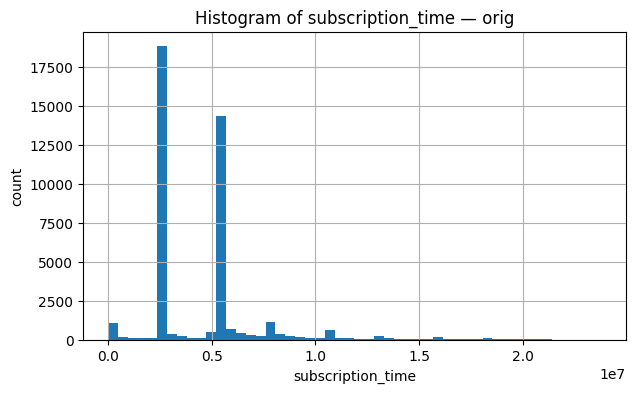


========== Processing minmax (/content/tinkof_minmax.csv) ==========

minmax columns (repr):
'application_id'
'subscription_time'
'channel_desc'
'region_size'
'trial_type'
'age_segment'
'res_segment'
Используем колонку: subscription_time
Пример первых 5 чисел (после парсинга):
[0.1616517463623172, 0.1127216792324386, 0.0036853905843536, 0.1166800782481022, 0.2219799434629465]


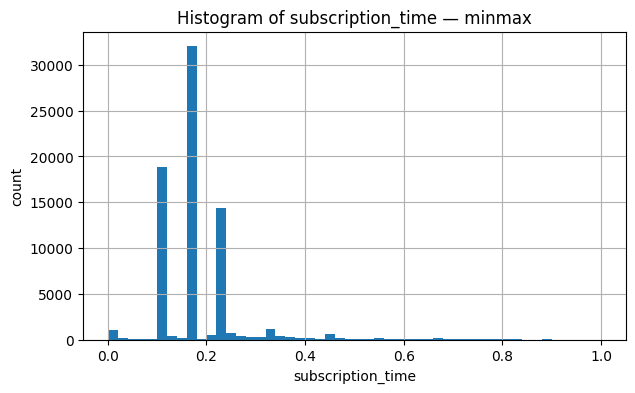


========== Processing z (/content/tinkof_zstandard.csv) ==========

z columns (repr):
'application_id'
'subscription_time'
'channel_desc'
'region_size'
'trial_type'
'age_segment'
'res_segment'
Используем колонку: subscription_time
Пример первых 5 чисел (после парсинга):
[-0.1784596284037283, -0.7301199207095767, -1.9594456583564173, -0.6854910925445177, 0.5017084727043022]


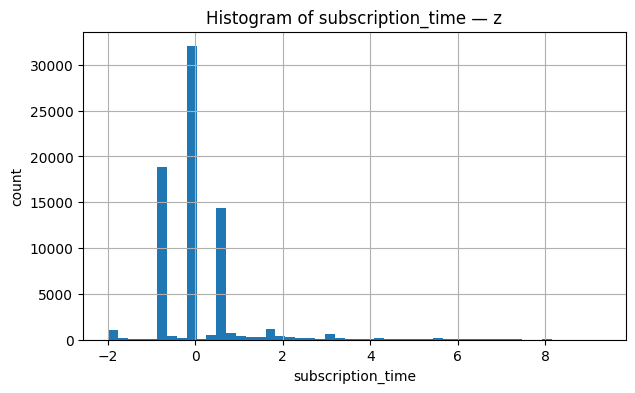

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

FILES = {
    "orig": "/content/tinkof.csv",
    "minmax": "/content/tinkof_minmax.csv",
    "z": "/content/tinkof_zstandard.csv"
}

def show_cols(df, name):
    print(f"\n{name} columns (repr):")
    for c in df.columns:
        print(repr(c))

def find_and_rename_subscription_col(df):
    # ищем колонку, похожую на 'subscription_time'
    target_key = "subscription_time"
    cleaned_map = {}
    for c in df.columns:
        # убираем BOM, пробелы, приводим к lower для сравнения
        c_clean = c.replace("\ufeff", "").strip().lower().replace(" ", "").replace("-", "_")
        cleaned_map[c] = c_clean
    # попробуем найти лучший матч
    for orig_col, clean_col in cleaned_map.items():
        if clean_col == target_key or clean_col.replace("_", "") == target_key.replace("_", ""):
            if orig_col != target_key:
                df.rename(columns={orig_col: target_key}, inplace=True)
            return target_key
    # ничего не нашлось — вернём None
    return None

def parse_numeric_series(srs):
    # простая и достаточно надёжная конвертация строк в числа:
    # - убираем пробелы и апострофы
    # - если есть и точка и запятая — считаем десятичным тот, что справа
    def parse_val(x):
        if pd.isna(x):
            return None
        xs = str(x).strip()
        if xs == "":
            return None
        xs = xs.replace("\u00A0", "").replace(" ", "").replace("'", "")
        has_dot = '.' in xs
        has_comma = ',' in xs
        try:
            if has_dot and has_comma:
                if xs.rfind('.') > xs.rfind(','):
                    xs = xs.replace(',', '')
                else:
                    xs = xs.replace('.', '').replace(',', '.')
            elif has_comma and not has_dot:
                parts = xs.split(',')
                if len(parts) > 1 and all(len(p) == 3 for p in parts[1:]):
                    xs = xs.replace(',', '')
                else:
                    xs = xs.replace(',', '.')
            return float(xs)
        except Exception:
            return None
    return srs.apply(parse_val).dropna().astype(float)

# основная логика: читаем, исправляем имя колонки, парсим и рисуем
for key, path in FILES.items():
    print("\n" + "="*10 + f" Processing {key} ({path}) " + "="*10)
    try:
        # попробуем автоматически угадать разделитель; если чтение падает — укажи sep=";" вручную
        try:
            df = pd.read_csv(path)
        except Exception:
            # если автоматическое чтение не прошло — пробуем с разделителем ;
            df = pd.read_csv(path, sep=";")
        show_cols(df, key)
        found = find_and_rename_subscription_col(df)
        if not found:
            print("Не удалось найти колонку, похожую на 'subscription_time'. Проверь имена выше.")
            continue
        print("Используем колонку:", found)
        nums = parse_numeric_series(df[found])
        if len(nums) == 0:
            print("После парсинга не осталось числовых значений.")
            continue
        print("Пример первых 5 чисел (после парсинга):")
        print(nums.head().to_list())
        # гистограмма
        plt.figure(figsize=(7,4))
        plt.hist(nums, bins=50)
        plt.title(f"Histogram of subscription_time — {key}")
        plt.xlabel("subscription_time")
        plt.ylabel("count")
        plt.grid(True)
        plt.show()
    except FileNotFoundError:
        print("Файл не найден:", path)
    except Exception as e:
        print("Ошибка при обработке:", e)

